# Attention Mechanism

You're reading a sentence. Your eyes don't give equal weight to every word. When you see "bank" in "I deposited money at the bank", you **attend** to "money" and "deposited" to understand it means a financial institution, not a river bank.

That's attention. And it changed everything in AI.

## The Problem with RNNs

Before attention, we used Recurrent Neural Networks (RNNs) for sequences. They process words one by one, left to right:

```
"The cat sat on the mat"
 ↓   ↓   ↓  ↓  ↓   ↓
h₁ → h₂ → h₃ → h₄ → h₅ → h₆
```

Each hidden state h captures information from all previous words. By the time you reach "mat", h₆ has to remember everything about "The cat sat on the".

**The bottleneck:** All context gets compressed into a single fixed-size vector.

Imagine summarizing a 50-word paragraph into a single sentence, then using only that sentence to answer questions. Information gets lost.

For long sequences, h₅₀ has mostly forgotten h₁. The network can't remember distant context.

## The Attention Insight

What if we kept ALL the hidden states and let the model **decide which ones matter**?

Instead of:
```
Encoder → single context vector → Decoder
```

We do:
```
Encoder → all hidden states → Decoder picks relevant ones
```

When translating "The cat sat on the mat" to French, generating "chat" (cat) should look mostly at "cat", not "mat". Attention makes this explicit.

**Core idea:** At each decoding step, compute a weighted combination of ALL encoder hidden states, where weights reflect relevance.

## How Attention Works: The Mechanism

Three steps:

**1. Score** - How relevant is each encoder state to the current decoder state?  
**2. Align** - Convert scores to probabilities (which sum to 1)  
**3. Combine** - Weighted average of encoder states

Let's walk through an example.

### Concrete Example

Translating "I love cats" → "J'adore les chats"

We've generated "J'adore" and now generating "les".

**Encoder hidden states** (one per input word):
```
h₁ = [0.1, 0.2, 0.3]  # "I"
h₂ = [0.4, 0.5, 0.6]  # "love" 
h₃ = [0.7, 0.8, 0.9]  # "cats"
```

**Decoder state:**
```
s = [0.5, 0.6, 0.7]  # Current state after generating "J'adore"
```

### Step 1: Score (Alignment Scores)

How relevant is each encoder word to what we're decoding?

Simplest method: **dot product** between decoder state and each encoder state.

```
score(s, h₁) = s · h₁ = (0.5)(0.1) + (0.6)(0.2) + (0.7)(0.3) = 0.38
score(s, h₂) = s · h₂ = (0.5)(0.4) + (0.6)(0.5) + (0.7)(0.6) = 0.92
score(s, h₃) = s · h₃ = (0.5)(0.7) + (0.6)(0.8) + (0.7)(0.9) = 1.46
```

Higher score = more relevant. "cats" (1.46) is most relevant to generating "les" (the plural article).

### Step 2: Align (Attention Weights)

Convert scores to probabilities using SOFTMAX.

```
e₁ = exp(0.38) = 1.46
e₂ = exp(0.92) = 2.51
e₃ = exp(1.46) = 4.31

sum = 1.46 + 2.51 + 4.31 = 8.28

α₁ = 1.46 / 8.28 = 0.18  # 18% attention to "I"
α₂ = 2.51 / 8.28 = 0.30  # 30% attention to "love"
α₃ = 4.31 / 8.28 = 0.52  # 52% attention to "cats"
```

The α values are **attention weights**. They sum to 1 and tell us how much to focus on each input word.

### Step 3: Combine (Context Vector)

Weighted average of encoder states:

```
c = α₁·h₁ + α₂·h₂ + α₃·h₃
  = 0.18·[0.1, 0.2, 0.3] + 0.30·[0.4, 0.5, 0.6] + 0.52·[0.7, 0.8, 0.9]
  = [0.018, 0.036, 0.054] + [0.12, 0.15, 0.18] + [0.364, 0.416, 0.468]
  = [0.502, 0.602, 0.702]
```

This **context vector** c is a weighted blend emphasizing "cats" (52%) over "love" (30%) and "I" (18%).

The decoder uses c along with its current state to generate the next word.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Implementation: Basic Attention

In [2]:
def attention(decoder_state, encoder_states):
    """
    Compute attention weights and context vector.
    
    Args:
        decoder_state: shape (hidden_dim,)
        encoder_states: shape (seq_len, hidden_dim)
    
    Returns:
        context: shape (hidden_dim,)
        weights: shape (seq_len,)
    """
    # Step 1: Score - dot product
    scores = encoder_states @ decoder_state
    
    # Step 2: Align - softmax
    weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Step 3: Combine - weighted sum
    context = weights @ encoder_states
    
    return context, weights

Let's test it with our example:

In [3]:
# Encoder states for "I love cats"
encoder_states = np.array([
    [0.1, 0.2, 0.3],  # "I"
    [0.4, 0.5, 0.6],  # "love"
    [0.7, 0.8, 0.9],  # "cats"
])

# Decoder state after generating "J'adore"
decoder_state = np.array([0.5, 0.6, 0.7])

context, weights = attention(decoder_state, encoder_states)

print("Attention weights:")
for i, (word, weight) in enumerate(zip(["I", "love", "cats"], weights)):
    print(f"  {word:5s}: {weight:.3f} ({weight*100:.1f}%)")

print(f"\nContext vector: {context}")

Attention weights:
  I    : 0.177 (17.7%)
  love : 0.303 (30.3%)
  cats : 0.520 (52.0%)

Context vector: [0.50306239 0.60306239 0.70306239]


The model attends most to "cats" (52%) because it's generating the plural article "les". This makes semantic sense.

## Visualizing Attention

Let's see attention across multiple decoding steps.

In [4]:
def visualize_attention(attention_matrix, source_words, target_words):
    """
    Heatmap showing which source words each target word attends to.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(attention_matrix, cmap='Blues', aspect='auto')
    
    ax.set_xticks(np.arange(len(source_words)))
    ax.set_yticks(np.arange(len(target_words)))
    ax.set_xticklabels(source_words)
    ax.set_yticklabels(target_words)
    
    ax.set_xlabel('Source (English)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Target (French)', fontsize=12, fontweight='bold')
    ax.set_title('Attention Weights', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(target_words)):
        for j in range(len(source_words)):
            text = ax.text(j, i, f'{attention_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

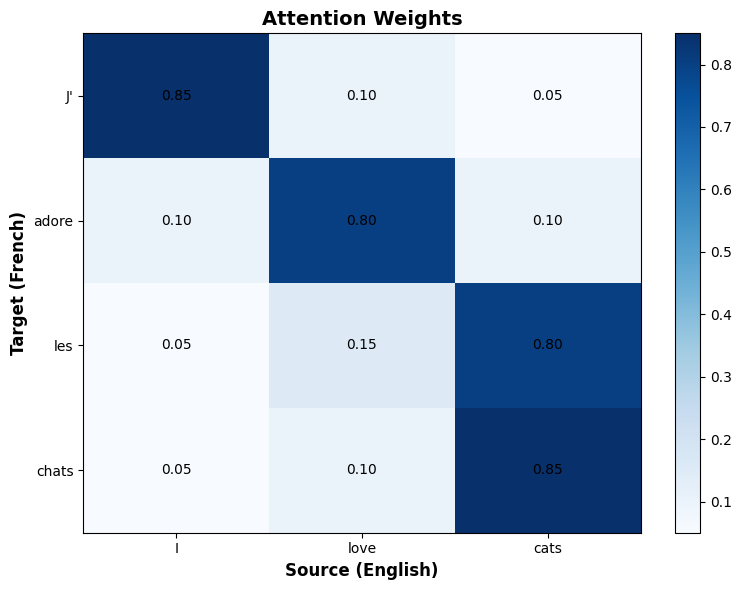

In [5]:
# Simulate attention for full translation
source = ["I", "love", "cats"]
target = ["J'", "adore", "les", "chats"]

# Example attention matrix (each row = attention for one target word)
attention_matrix = np.array([
    [0.85, 0.10, 0.05],  # "J'" attends mostly to "I"
    [0.10, 0.80, 0.10],  # "adore" attends mostly to "love"
    [0.05, 0.15, 0.80],  # "les" attends mostly to "cats" (plural marker)
    [0.05, 0.10, 0.85],  # "chats" attends mostly to "cats"
])

visualize_attention(attention_matrix, source, target)

Notice the diagonal pattern. Each French word attends primarily to its English counterpart. This is called **alignment**, and it's what attention learns automatically.

## Variants: Different Scoring Functions

We used dot product: `score(s, h) = s · h`

Other common scoring functions:

### 1. Additive (Bahdanau Attention)

**score(s, h) = v · tanh(W₁·s + W₂·h)**

Concatenate, transform with neural network, then project to scalar. More parameters, more flexible.

In [6]:
class AdditiveAttention:
    def __init__(self, hidden_dim):
        self.W1 = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.W2 = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.v = np.random.randn(hidden_dim) * 0.1
    
    def score(self, decoder_state, encoder_states):
        s_transformed = encoder_states @ self.W1
        h_transformed = decoder_state @ self.W2
        combined = np.tanh(s_transformed + h_transformed)
        scores = combined @ self.v
        return scores
    
    def __call__(self, decoder_state, encoder_states):
        scores = self.score(decoder_state, encoder_states)
        weights = np.exp(scores) / np.sum(np.exp(scores))
        context = weights @ encoder_states
        return context, weights

### 2. Scaled Dot Product

**score(s, h) = (s · h) / √d**

Same as dot product but scaled by square root of dimension. Prevents very large scores that make softmax saturate. This is what Transformers use.

In [7]:
def scaled_dot_product_attention(decoder_state, encoder_states):
    hidden_dim = decoder_state.shape[0]
    
    # Scaled scores
    scores = (encoder_states @ decoder_state) / np.sqrt(hidden_dim)
    
    # Softmax
    weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Context
    context = weights @ encoder_states
    
    return context, weights

## Why Scaling Matters

Without scaling, dot products grow with dimension.

In [8]:
# High dimensional example
np.random.seed(42)
dim = 512
s = np.random.randn(dim)
h1 = np.random.randn(dim)
h2 = np.random.randn(dim)

score1_unscaled = s @ h1
score2_unscaled = s @ h2

print(f"Unscaled scores: {score1_unscaled:.2f}, {score2_unscaled:.2f}")
print(f"Difference: {abs(score1_unscaled - score2_unscaled):.2f}")

score1_scaled = (s @ h1) / np.sqrt(dim)
score2_scaled = (s @ h2) / np.sqrt(dim)

print(f"\nScaled scores: {score1_scaled:.2f}, {score2_scaled:.2f}")
print(f"Difference: {abs(score1_scaled - score2_scaled):.2f}")

Unscaled scores: -5.01, 36.18
Difference: 41.19

Scaled scores: -0.22, 1.60
Difference: 1.82


Large unscaled scores push softmax into regions where gradients vanish. The difference between exp(30) and exp(31) is meaningless to softmax - both are effectively 1.0 after normalization.

Scaling keeps scores reasonable, preserving gradient flow.

## Complete Example: Sequence-to-Sequence with Attention

Let's build a minimal seq2seq model that uses attention.

In [9]:
class Seq2SeqWithAttention:
    def __init__(self, hidden_dim):
        self.hidden_dim = hidden_dim
    
    def encode(self, sequence):
        """
        Simulate encoder producing hidden states.
        In reality, this would be an RNN/LSTM.
        """
        seq_len = len(sequence)
        # Random encoder states for demo
        encoder_states = np.random.randn(seq_len, self.hidden_dim) * 0.1
        return encoder_states
    
    def decode_step(self, decoder_state, encoder_states):
        """
        Single decoding step with attention.
        """
        # Compute attention
        context, weights = attention(decoder_state, encoder_states)
        
        # Combine decoder state with context
        # In reality: next_state = RNN(decoder_state, context)
        next_state = decoder_state * 0.5 + context * 0.5
        
        return next_state, weights
    
    def decode(self, encoder_states, num_steps):
        """
        Decode multiple steps, collecting attention weights.
        """
        decoder_state = np.random.randn(self.hidden_dim) * 0.1
        attention_weights = []
        
        for _ in range(num_steps):
            decoder_state, weights = self.decode_step(decoder_state, encoder_states)
            attention_weights.append(weights)
        
        return np.array(attention_weights)

Encoder states shape: (6, 8)
Attention weights shape: (7, 6)


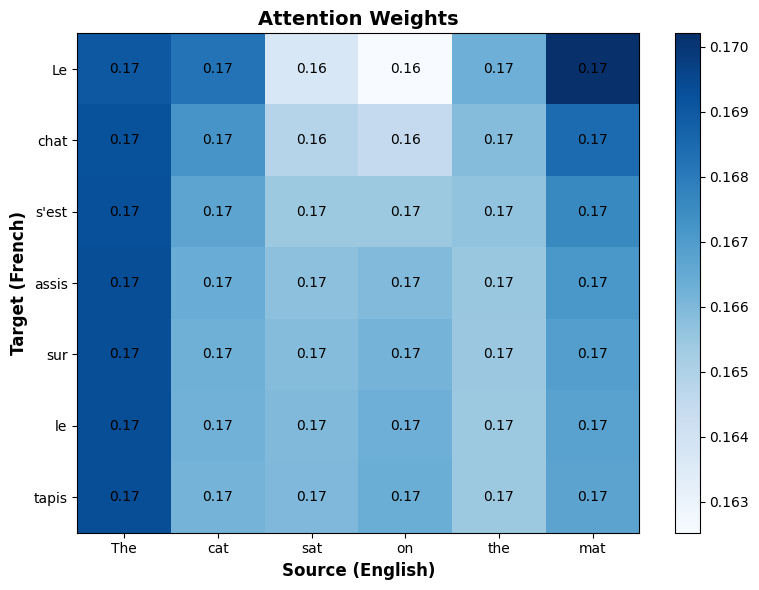

In [10]:
# Demo
source_sentence = ["The", "cat", "sat", "on", "the", "mat"]
target_sentence = ["Le", "chat", "s'est", "assis", "sur", "le", "tapis"]

model = Seq2SeqWithAttention(hidden_dim=8)

# Encode
encoder_states = model.encode(source_sentence)
print(f"Encoder states shape: {encoder_states.shape}")

# Decode
attention_weights = model.decode(encoder_states, num_steps=len(target_sentence))
print(f"Attention weights shape: {attention_weights.shape}")

# Visualize
visualize_attention(attention_weights, source_sentence, target_sentence)

## What Attention Achieves

**1. No bottleneck** - All encoder states available, not compressed into one vector

**2. Long-range dependencies** - Word 50 can directly attend to word 1

**3. Interpretability** - Attention weights show what the model "looks at"

**4. Better gradients** - Direct path from output to any input

This mechanism was revolutionary. But there's a twist we haven't covered: **self-attention**, where a sequence attends to itself.

That's the foundation of Transformers.

## Key Takeaways

**Attention is:**
- A way to compute weighted combinations based on relevance
- Three steps: score, align (softmax), combine
- A solution to the sequential bottleneck in RNNs

**The mechanism:**
- Scores measure similarity (dot product, additive, etc.)
- Softmax converts scores to probabilities
- Weighted sum produces context vector

**Why it matters:**
- All input positions are accessible at once
- Model learns what to focus on
- Foundation for Transformers and modern LLMs

Next: Self-attention, where sequences attend to themselves.